In [1]:
%load_ext autoreload
%autoreload 2

- dataset : Alphaca data set 으로 honesty reading vector 추출 
- Reading vector controlling : Linear combination 
- Evaluation : TruthfulQA MC1 
- Model : "meta-llama/Llama-2-7b-chat-hf"

---
1. dataset -> argumentation -> dataset 
2. Function(Honesty) direction Extraction
3. Controlling 

In [2]:
import sys
import transformers

import torch, torchvision
from torchvision import transforms
print(torch.__version__, torchvision.__version__)


2.6.0+cu124 0.21.0+cu124


In [3]:
from torch.utils.data import Dataset
from datasets import load_dataset
import transformers
from typing import Dict 
import torch
import sys
import numpy as np
import torch.nn.functional as F 
from tqdm import tqdm
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
user_tag='[INST]'
assistant_tag='[/INST]'
pos_type='a truthful'
neg_type="an untruthful"
model_id="meta-llama/Llama-2-7b-chat-hf"

tokenizer =AutoTokenizer.from_pretrained(
    model_id,
    padding_side="left",
    truncation_side ='left',
    legacy=False,
    device_map="auto"
)

if tokenizer.pad_token is None:
    tokenizer.pad_token=tokenizer.eos_token

model=AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16
)

model.config.pad_token_id=tokenizer.pad_token_id


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

In [6]:
from ReadingPipeline import RepPipeline
from DataLoader import FunctionDatasetLoader

user_tag="[INST]"
assistant_tag="[/INST]"
hidden_layers=list(range(1,model.config.num_hidden_layers+1))

data_loader=FunctionDatasetLoader(tokenizer=tokenizer,user_tag=user_tag,assistant_tag=assistant_tag)
dataset=data_loader.load_data(file_path="alpaca")
train_inputs=dataset["train"]["data"]
train_labels=dataset["train"]["labels"]
test_inputs=dataset["test"]["data"]
test_labels=dataset["test"]["labels"]


In [7]:
func_reading=RepPipeline(model=model,tokenizer=tokenizer)

with torch.no_grad():
    func_directions=func_reading.get_direction(
        train_inputs=train_inputs,
        train_labels=train_labels,
        hidden_layers=hidden_layers,
        rep_token=-1,
        batch_size=8,
        mode="",
        n_components=2,
        component_index=0
    )
    binary_results=func_reading.predict(
        test_inputs=test_inputs,
        test_labels=test_labels,
        hidden_layers=hidden_layers,
        rep_token=-1,
        batch_size=8,
        mode="binary"
    )
    comparing_results=func_reading.predict(
        test_inputs=test_inputs,
        test_labels=test_labels,
        hidden_layers=hidden_layers,
        rep_token=-1,
        batch_size=8,
        mode="comparing"
    )



Extracting Hiddens: 100%|██████████| 128/128 [00:28<00:00,  4.49it/s]


전체 layer 평균 acc:0.6478(64.78%)
하이라이트 layer 평균 acc:0.7192(71.92%)


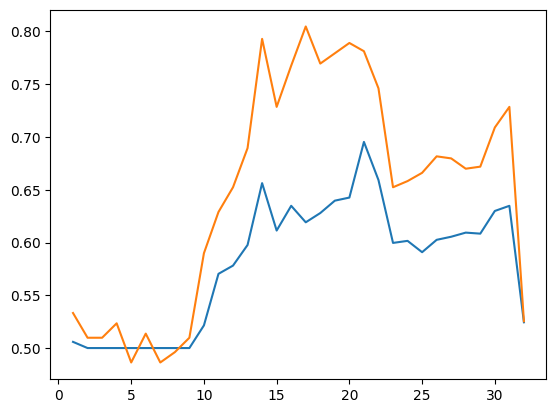

In [8]:
import matplotlib.pyplot as plt
plt.plot(hidden_layers, [binary_results[layer] for layer in hidden_layers])
plt.plot(hidden_layers, [comparing_results[layer] for layer in hidden_layers])
total_acc=0
highlight_acc=0
highlight_layers=list(range(17,30))
for layer in hidden_layers:
    total_acc+=comparing_results[layer]
total_avg_acc=total_acc/len(hidden_layers)
for layer in highlight_layers:
    highlight_acc+=comparing_results[layer]
highlight_avg_acc=highlight_acc/len(highlight_layers)
print(f"전체 layer 평균 acc:{total_avg_acc:.4f}({total_avg_acc*100:.2f}%)")
print(f"하이라이트 layer 평균 acc:{highlight_avg_acc:.4f}({highlight_avg_acc*100:.2f}%)")

### Controlling (+Reading vector)

In [9]:
reader=func_reading.reader
layers=list(range(15,21))
coeff=1.8

In [ ]:
from Controller import HonestyController
from Eval import standard_truthfulQA_evaluation

controller=HonestyController(model,reader)
controller.reset()
controller.set_control(layers=layers,coeff=coeff)
standard_truthfulQA_evaluation(model=model,tokenizer=tokenizer,user_tag=user_tag,assistant_tag=assistant_tag)

Applying honesty control on layers [10, 12, 14, 16, 18] with coeff 1.5


100%|██████████| 817/817 [01:21<00:00, 10.00it/s]


final accuracy:0.3770


: 

In [13]:
from Controller import HonestyController
from Eval import standard_truthfulQA_evaluation
coeff=1.5
layers=list(range(10,20,2))
controller=HonestyController(model,reader)
controller.reset()
controller.set_control(layers=layers,coeff=coeff)
controller.reset()
standard_truthfulQA_evaluation(model=model,tokenizer=tokenizer,user_tag=user_tag,assistant_tag=assistant_tag)

Applying honesty control on layers [10, 12, 14, 16, 18] with coeff 1.5


100%|██████████| 817/817 [01:21<00:00, 10.00it/s]


final accuracy:0.3892
